#CNN Model for Sign Language Recognition

##Prepare Dataset

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

In [ ]:
DATA_PATH = '/content/drive/MyDrive/DLProject/mnist/'

In [ ]:
train_dataset = pd.read_csv(DATA_PATH + 'sign_mnist_train.csv')
test_dataset = pd.read_csv(DATA_PATH + 'sign_mnist_test.csv')

In [ ]:
train_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
# splitting data and normalize images
x_train = train_dataset.iloc[:, 1:].to_numpy() / 255.0 
y_train = train_dataset['label'].to_numpy()
x_test = test_dataset.iloc[:, 1:].to_numpy() / 255.0
y_test = test_dataset['label'].to_numpy()

# reshape images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# one-hot encoding labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(24709, 28, 28, 1)
(24709, 25)


##Train CNN Model

###Model

In [ ]:
# Set the CNN model 
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(25, activation = "softmax"))

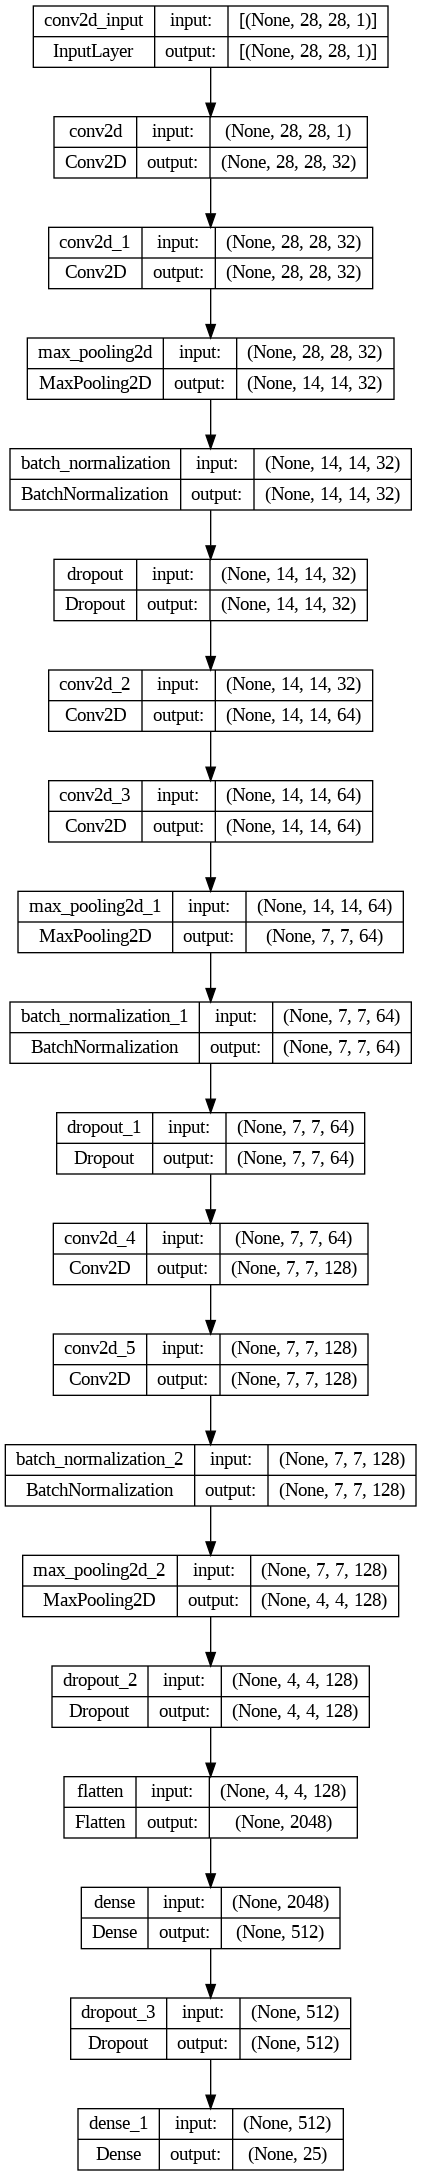

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

###MNIST

In [ ]:
# Define optimizer and use learning rate reduction
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

datagen.fit(x_train)

In [ ]:
# Training parameters
epochs = 50 
batch_size = 128 

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

In [ ]:
# Fit the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_val, y_val), 
                              verbose=2, callbacks=[model_checkpoint_callback,learning_rate_reduction,early_stopping])

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##Predict MNIST 

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
# Predict on test set
preds = model.predict(x_test)

In [ ]:
preds = np.argmax(preds, axis=1) 
targets = np.argmax(y_test, axis=1) 
cm = confusion_matrix(targets, preds)

In [ ]:
print(classification_report(targets, preds))

In [ ]:
plt.figure(figsize=(20,15))

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

##Prepare ASL Dataset

In [ ]:
# data_dir = '/content/drive/MyDrive/DLProject/asl/'
data_dir = '/content/drive/MyDrive/DLProject/arabic/'

In [ ]:
x = np.load(data_dir + 'images_32.npy')
y = np.load(data_dir + 'labels_32.npy')
x = x.astype('float32') / 255.0
y = tf.keras.utils.to_categorical(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4713, 32, 32, 3) (4713, 31)
(1572, 32, 32, 3) (1572, 31)


In [ ]:
classes = 31
batch_size = 32
epochs = 100
learning_rate = 1e-4

In [ ]:
# Set the CNN model 
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'same', 
                 activation ='relu', input_shape = (32,32,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
# model.add(Dropout(0.3))
model.add(Dense(classes, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        102464    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(x_train)

In [ ]:
# Define optimizer and use learning rate reduction
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_val, y_val), 
                              verbose=2, callbacks=[model_checkpoint_callback,learning_rate_reduction,early_stopping])

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.03308, saving model to best.h5
148/148 - 19s - loss: 3.8287 - accuracy: 0.0365 - val_loss: 3.5825 - val_accuracy: 0.0331 - lr: 1.0000e-04 - 19s/epoch - 126ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.03308 to 0.04135, saving model to best.h5
148/148 - 4s - loss: 3.4483 - accuracy: 0.0327 - val_loss: 3.5567 - val_accuracy: 0.0413 - lr: 1.0000e-04 - 4s/epoch - 30ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.04135
148/148 - 4s - loss: 3.4452 - accuracy: 0.0363 - val_loss: 3.4568 - val_accuracy: 0.0382 - lr: 1.0000e-04 - 4s/epoch - 24ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.04135
148/148 - 3s - loss: 3.4332 - accuracy: 0.0395 - val_loss: 3.4370 - val_accuracy: 0.0407 - lr: 1.0000e-04 - 3s/epoch - 22ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.04135 to 0.05216, saving model to best.h5
148/148 - 4s - loss: 3.4332 - accuracy: 0.0416 - val_loss: 3.4242 - val_accur

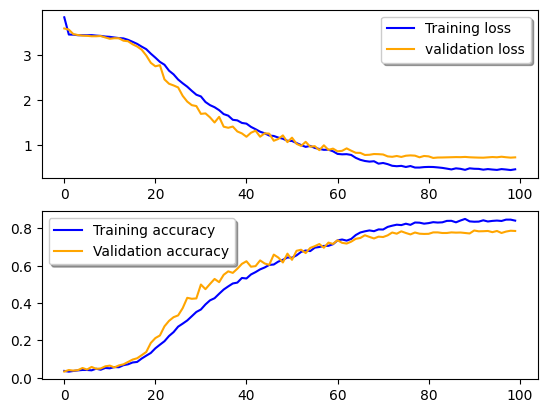

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##Predict ASL

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
model = tf.keras.models.load_model('best.h5')
print("Accuracy of the model is - " , model.evaluate(x_test, y_test)[1]*100 , "%")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 2s 24ms/step - loss: 0.7852 - accuracy: 0.7767
Accuracy of the model is -  77.67175436019897 %


In [ ]:
# Predict on test set
preds = model.predict(x_test)

50/50 [==============================] - 1s 12ms/step


In [ ]:
preds = np.argmax(preds, axis=1) 
targets = np.argmax(y_test, axis=1) 
cm = confusion_matrix(targets, preds)

In [ ]:
np.save(data_dir + 'cnn_cm_5', cm)
np.save(data_dir + 'cnn_targets_5', targets)
np.save(data_dir + 'cnn_preds_5', preds)

In [ ]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        54
           1       0.76      0.74      0.75        43
           2       0.53      0.60      0.56        45
           3       0.76      0.65      0.70        40
           4       0.81      0.68      0.74        65
           5       0.94      0.91      0.92        53
           6       0.72      0.81      0.77        54
           7       0.92      0.92      0.92        49
           8       0.93      0.91      0.92        44
           9       0.85      0.73      0.79        48
          10       0.71      0.85      0.77        52
          11       0.60      0.82      0.69        50
          12       0.84      0.89      0.87        55
          13       0.75      0.88      0.81        58
          14       0.80      0.66      0.72        61
          15       0.57      0.54      0.56        50
          16       0.90      0.69      0.78        55
          17       0.83    

<Axes: >

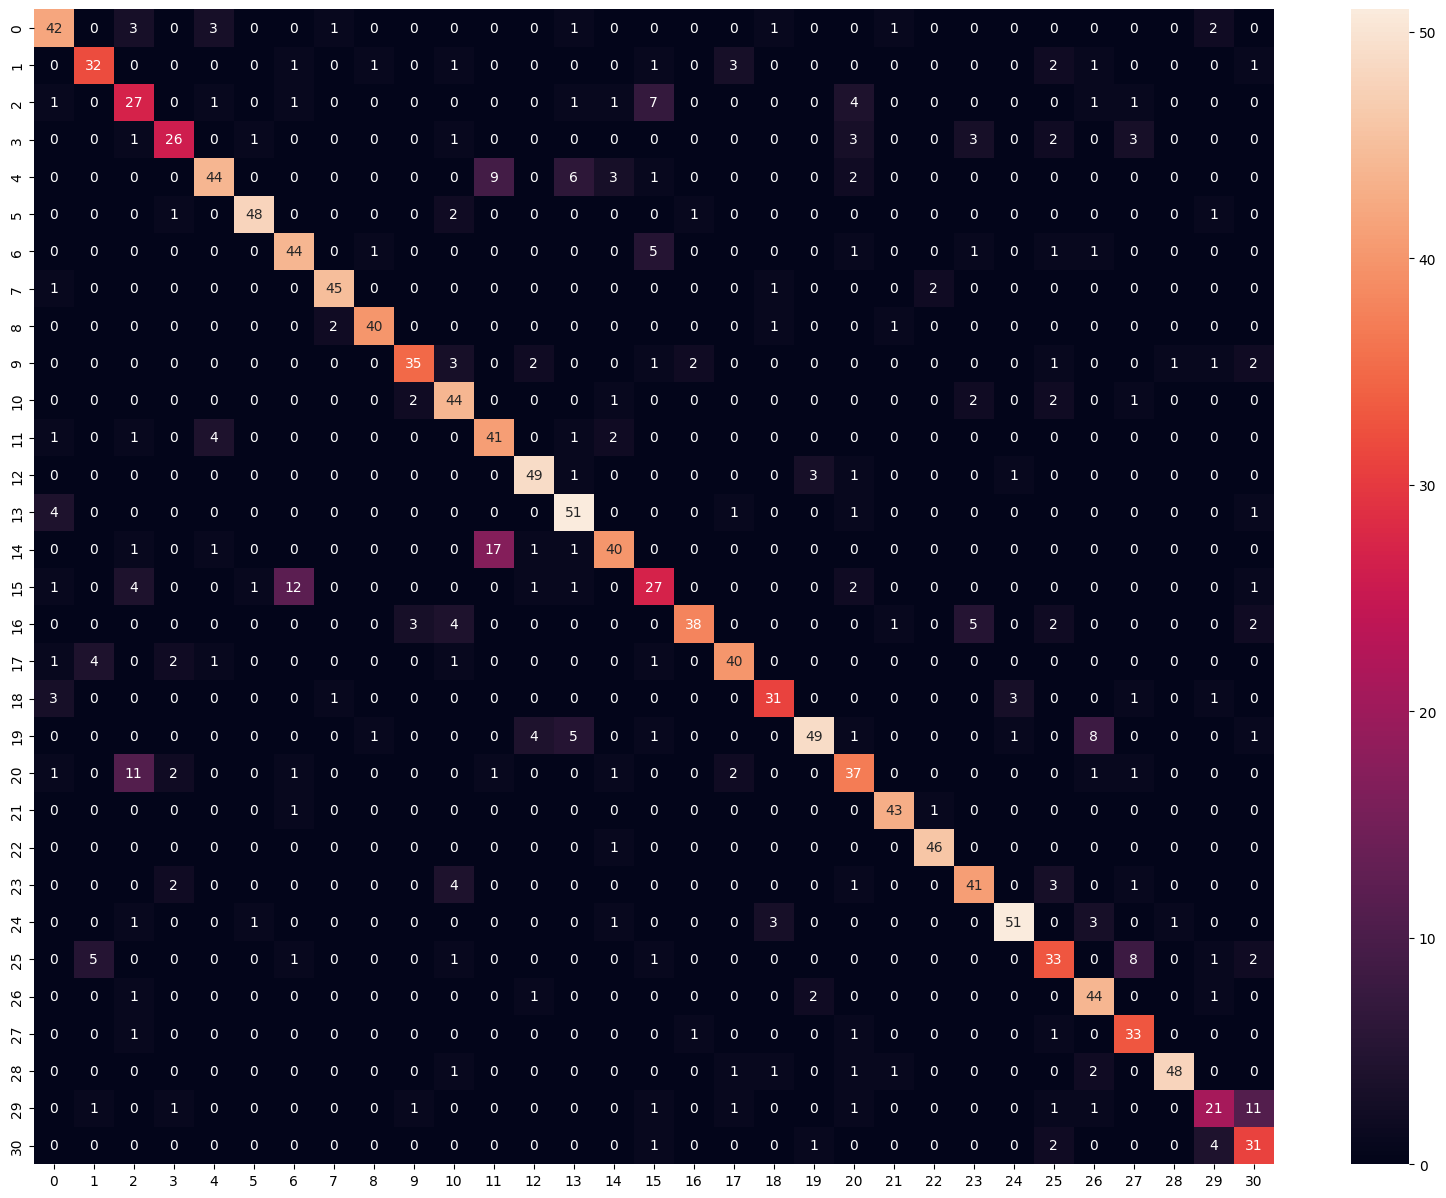

In [ ]:
plt.figure(figsize=(20,15))

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")